# Hands-on Lesson 6 - Backpropagation #

The goal of this hands-on lesson is to code a backpropagation algorithm. This backpropagation algorithm is needed to implement a gradient descent method of learning for a neural network.  

In [1]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pyplot as plt

## Function to be fitted

We want to approach the following function with a neural network
$$f(x_1,x_2) = 1+ (1 - x_1 + x_1^2) \sin(\pi x_2) + \varepsilon$$
where $\varepsilon$ is a stochastic variable with normal distribution of zero mean and $\sigma=0.1$ standard deviation.

In [2]:
def f_deterministic(x):
    f = 1 + (1-x[1]+x[1]**2) * np.sin(np.pi * x[2])
    return f

def f_stochastic(x):
    f = 1 + (1-x[1]+x[1]**2) * np.sin(np.pi * x[2]) + np.random.normal(scale=0.1,size=x[1].shape)
    return f

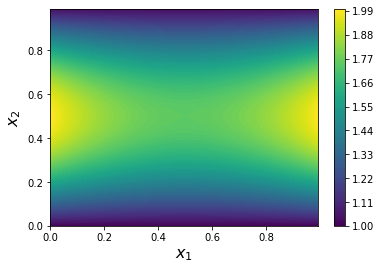

In [3]:
plt.figure()
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)

x1 = np.arange(0, 1, 0.01)
x2 = np.arange(0, 1, 0.01)
xx1, xx2 = np.meshgrid(x1, x2)
xx0 = np.ones(xx1.shape)
xx = np.stack((xx0, xx1, xx2), axis=0)
z = f_deterministic(xx)
h = plt.contourf(x1,x2,z,100)
cbar = plt.colorbar(h)


## Neural network
We build a neural network with 4 layers. Each layer has $N_l$ neurons. We use the notations $p^{(l)}$ and $o^{(l)}$ for the predecessor and output vectors of neurons in layer $l$ ($l=0\ldots L$). The matrices of synaptic weights are noted $\Theta^{(l)}$. 

### Feedforward calculation
The feedforward calculation aims at calculating $h_\theta(x)$ using the following feedforward procedure
\begin{align}
o^{(0)} & = x \\
p^{(1)} & = \Theta^{(0)}\cdot o^{(0)}\\
o^{(1)} & = g\left( p^{(1)} \right) \\
p^{(2)} & = \Theta^{(1)}\cdot o^{(1)}\\
o^{(2)} & = g\left( p^{(2)} \right) \\
p^{(3)} & = \Theta^{(2)}\cdot o^{(2)}\\
o^{(3)} & = p^{(3)} \\
h_\theta(x) & = o^{(3)}
\end{align}
where $x=[1, x_1, x_2]$ and $g$ is a non-linear "sigmoid" function. 

In [4]:
# Number of neurons in each layer
N0 = 3  # x0 = 1, x1, x2
N1 = 16
N2 = 16
N3 = 1  # OUTPUT
Ns = (N0, N1, N2, N3)

# Random initialisation of matrices
Theta0 = np.random.normal(scale=1.0,size=(Ns[1],Ns[0]))
Theta1 = np.random.normal(scale=1.0,size=(Ns[2],Ns[1]))
Theta2 = np.random.normal(scale=1.0,size=(Ns[3],Ns[2]))
Thetas = (Theta0, Theta1, Theta2)

In [5]:
def NLfunction(p):
    f = np.maximum(0,p)
    fprime = 0.5 + 0.5*np.sign(p)
    # f = np.tanh(p)
    # fprime = 1 - np.tanh(p)**2
    # f = 1/(1+np.exp(-p))
    # fprime = f * (1-f)
    return f, fprime

In [6]:
def NN(Thetas, x):
    o0 = x
    p1 = Thetas[0].dot(o0)
    o1, gp1 = NLfunction(p1)
    p2 = Thetas[1].dot(o1)
    o2, gp2  = NLfunction(p2)
    p3 = Thetas[2].dot(o2)
    o3 = p3
    gp3 = 1
    
    os = (o0, o1, o2, o3)
    gps= (1, gp1, gp2, gp3)
    h = o3
    return h, os, gps    

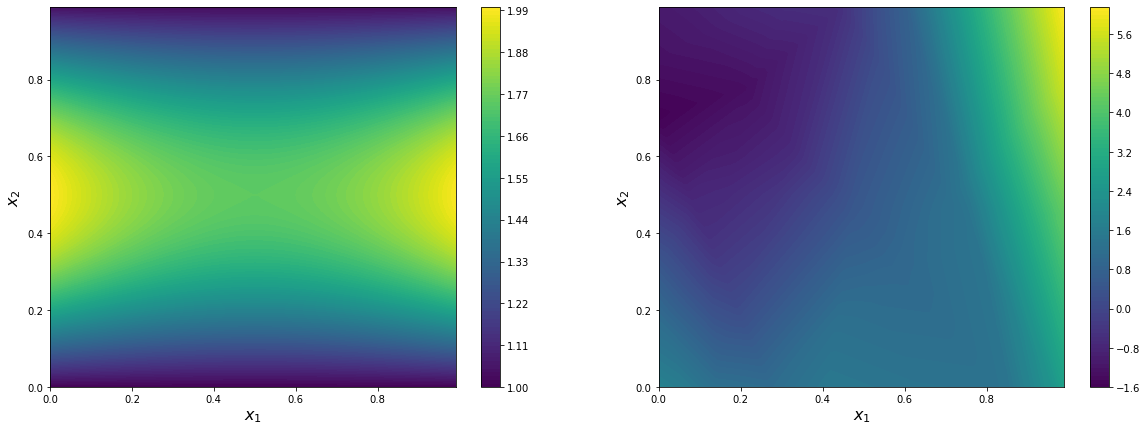

In [7]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
x1 = np.arange(0, 1, 0.01)
x2 = np.arange(0, 1, 0.01)
xx1, xx2 = np.meshgrid(x1, x2)
xx0 = np.ones(xx1.shape)
xx0.shape
xx1.shape
xx = np.stack((xx0, xx1, xx2), axis=0)

z = f_deterministic(xx)
h = plt.contourf(x1,x2,z,100)
cbar = plt.colorbar(h)

plt.subplot(122)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
zz = np.zeros(xx1.shape)
for i in range(xx0.shape[0]):
    for j in range(xx0.shape[1]):
        zz[i,j],_ ,_ = NN(Thetas, np.array(xx[:,i,j])) 
h = plt.contourf(x1,x2,zz,100)
cbar = plt.colorbar(h)



## Backpropagation algorithm

As we have seen in Lesson 5, the backpropagation algorithm consists first in calculating the vectors $\delta^{(l)}$ for each layer starting by the output layer $l=L=2$ and calculating $\delta$'s for each layer recursively. 

\begin{align}
\delta^{(L)} & = (h_\theta(x) - y)* g'(p^{(L)}) \\
\delta^{(l)} & = \left(\Theta^{(l)}\right)^T \cdot \delta^{(l+1)} * g'\left(p^{(l)}\right)
\end{align}

Once these vectors $\delta$ are calculated the gradients are obtained with this formula
$$D^{(l)}_{ij}\equiv \frac{\partial E}{\partial \Theta_{ij}^{(l)}} = \delta_i^{(l+1)} o_j^{(l)}$$
where $E=\tfrac{1}{2} \left( h_\theta(x) - y \right)^2$ is the quadratic error. 

In [13]:
x = np.random.rand(3)
x[0]=1
print(x)

h, os, gps = NN(Thetas, x)
delta3 = (h-f_deterministic(x)) * gps[3]
delta2 = np.transpose(Thetas[2]).dot(delta3) * gps[2]
delta1 = np.transpose(Thetas[1]).dot(delta2) * gps[1]
print(delta1, delta2, delta3)

D0 = np.outer(delta1,os[0])
D1 = np.outer(delta2,os[1])
D2 = np.outer(delta3,os[2])

# print("T0",Thetas[0], "T1",Thetas[1], "T2",Thetas[2])
print("D0",D0,"D1", D1,"D2", D2)

[ 1.          0.03003848  0.50572814]
[ -0.           4.80536989  19.55045181 -13.4637276   -0.          -0.
   7.71090231   0.          44.22040887  -0.          -8.84060288  -0.           0.
  -0.          -0.          -0.        ] [-10.78943052   0.           0.           0.          -0.           8.05440262
   0.81041173   0.          -0.           7.94633903   0.          -0.87084061
  -0.           4.50529935  -0.          -9.05189216] [-5.62613809]
D0 [[ -0.          -0.          -0.        ]
 [  4.80536989   0.14434601   2.43021079]
 [ 19.55045181   0.58726587   9.88721371]
 [-13.4637276   -0.40442992  -6.80898597]
 [ -0.          -0.          -0.        ]
 [ -0.          -0.          -0.        ]
 [  7.71090231   0.23162379   3.89962032]
 [  0.           0.           0.        ]
 [ 44.22040887   1.32831389  22.36350531]
 [ -0.          -0.          -0.        ]
 [ -8.84060288  -0.26555828  -4.47094169]
 [ -0.          -0.          -0.        ]
 [  0.           0.           0. 

## Verification of backpropagation algorithm
We want to assess whether the calculation of the gradient ${\partial E}\,/\,{\partial \Theta_{ij}^{(l)}}$ is correct. To do so, we will compare a component of the matrix $D^{(l)}$ with an approximate value of the gradient obtained by calculating 
$$\tilde D_{ij} = \frac{E(\Theta_{ij} + \epsilon) - E(\Theta_{ij})}{\epsilon}$$

In [14]:
x = np.random.rand(3)
x[0]=1
print(x)

h, os, gps = NN(Thetas, x)
delta3 = (h - f_deterministic(x)) * gps[3]
delta2 = np.transpose(Thetas[2]).dot(delta3) * gps[2]
delta1 = np.transpose(Thetas[1]).dot(delta2) * gps[1]

D0 = np.outer(delta1,os[0])
D1 = np.outer(delta2,os[1])
D2 = np.outer(delta3,os[2])

E = 0.5*(h-f_deterministic(x))**2

epsilon = 1E-6

Theta2 = Thetas
Theta2[0][2,0] += epsilon
h2, _, _ = NN(Theta2, x)

E2 = 0.5*(h2-f_deterministic(x))**2

Dtilde = (E2-E) / epsilon

print("D:", D0[2,0], "// Dtilde:", Dtilde[0])


[ 1.          0.48874128  0.07942139]
D: 7.08809707465 // Dtilde: 7.08810311156


## Stochastic gradient descent
We recall the principle of stochastic gradient descent. It is a loop where the following actions are performed. 
- Pick an data point $(x^{(i)},y^{(i)})$
- Calculate the gradient matrices $D^{(l)}$ for this point
- Update the matrices $\Theta^{(l)}$
$$\Theta^{(l)} := \Theta^{(l)} - \alpha \,D^{(l)}$$
where $\alpha$ is the learning parameter.

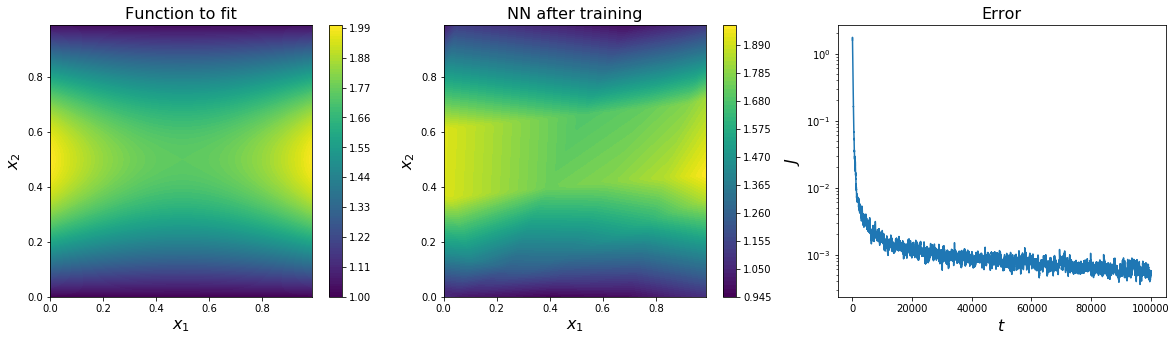

In [15]:
alpha = 0.01       # Learning parameter
Nsamples = 100000  # Number of samples

# Training set
x = np.random.rand(3,Nsamples)
x[0] = np.ones(Nsamples)
y = f_deterministic(x)

# Random initialisation of matrices
Theta0 = np.random.normal(scale=1.0,size=(Ns[1],Ns[0]))
Theta1 = np.random.normal(scale=1.0,size=(Ns[2],Ns[1]))
Theta2 = np.random.normal(scale=1.0,size=(Ns[3],Ns[2]))
Thetas = (Theta0, Theta1, Theta2)

J = np.zeros(Nsamples)
error = 1
for t in range(Nsamples):
    xi = x[:,t]
    yi = y[t]

    h, os, gps = NN(Thetas, xi)
    delta3 = (h - yi) * gps[3]
    delta2 = np.transpose(Thetas[2]).dot(delta3) * gps[2]
    delta1 = np.transpose(Thetas[1]).dot(delta2) * gps[1]
    D0 = np.outer(delta1,os[0])
    D1 = np.outer(delta2,os[1])
    D2 = np.outer(delta3,os[2])
    Theta0 = Thetas[0] - alpha * D0
    Theta1 = Thetas[1] - alpha * D1
    Theta2 = Thetas[2] - alpha * D2
    Thetas = (Theta0, Theta1, Theta2)
    error = 0.99 * error + 0.01*(0.5*delta3**2)
    J[t] = error

plt.figure(figsize=(20,5))

fig1 = plt.subplot(131)
fig1.set_title("Function to fit", fontsize=16)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
x1 = np.arange(0, 1, 0.01)
x2 = np.arange(0, 1, 0.01)
xx1, xx2 = np.meshgrid(x1, x2)
xx0 = np.ones(xx1.shape)
xx = np.stack((xx0, xx1, xx2), axis=0)
z = f_deterministic(xx)
h = plt.contourf(x1,x2,z,100)
cbar = plt.colorbar(h)

fig2 = plt.subplot(132)
fig2.set_title("NN after training", fontsize=16)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
zz = np.zeros(xx1.shape)
for i in range(xx0.shape[0]):
    for j in range(xx0.shape[1]):
        zz[i,j],_ ,_ = NN(Thetas, np.array(xx[:,i,j])) 
h = plt.contourf(x1,x2,zz,100)
cbar = plt.colorbar(h)

fig3 = plt.subplot(133)
fig3.set_title("Error", fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$J$', fontsize=16)
plt.semilogy(np.arange(Nsamples),J)

## Mini-batch gradient descent

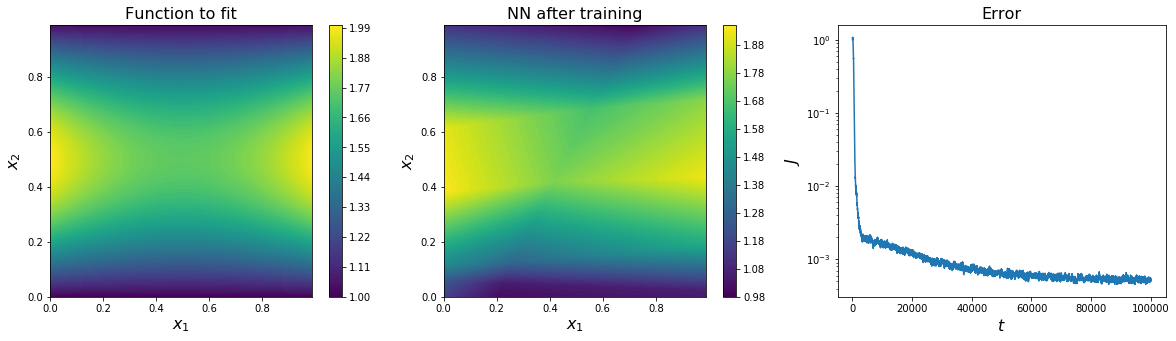

In [26]:
alpha = 0.005      # Learning parameter
Nsamples = 100000  # Number of samples
Nbatch = 4         # Size of mini-batch
Nstep = 100000     # Number of mini-batches for training

# Training set
# x = np.random.rand(3,Nsamples)
# x[0] = 1
# y = f_deterministic(x)

# Random initialisation of matrices
Theta0 = np.random.normal(scale=1.0,size=(Ns[1],Ns[0]))
Theta1 = np.random.normal(scale=1.0,size=(Ns[2],Ns[1]))
Theta2 = np.random.normal(scale=1.0,size=(Ns[3],Ns[2]))
Thetas = (Theta0, Theta1, Theta2)

J = np.zeros(Nstep)
error = 1
for t in range(Nstep):
    D0 = np.zeros(Thetas[0].shape)
    D1 = np.zeros(Thetas[1].shape)
    D2 = np.zeros(Thetas[2].shape)
    
    samples = np.random.randint(Nsamples, size=Nbatch)
    xis = x[:,samples]
    yis = y[samples]
    
    inc_error = 0
    for i in range(Nbatch):
        xi = xis[:,i]
        yi = yis[i]

        h, os, gps = NN(Thetas, xi)
        delta3 = (h - yi) * gps[3]
        delta2 = np.transpose(Thetas[2]).dot(delta3) * gps[2]
        delta1 = np.transpose(Thetas[1]).dot(delta2) * gps[1]
        D0 = D0 + np.outer(delta1,os[0])
        D1 = D1 + np.outer(delta2,os[1])
        D2 = D2 + np.outer(delta3,os[2])
        inc_error += 0.5*delta3**2 
    
    Theta0 = Thetas[0] - alpha * D0 
    Theta1 = Thetas[1] - alpha * D1 
    Theta2 = Thetas[2] - alpha * D2 
    Thetas = (Theta0, Theta1, Theta2)
    error = 0.99 * error + 0.01*inc_error / Nbatch
    J[t] = error

plt.figure(figsize=(20,5))

fig1 = plt.subplot(131)
fig1.set_title("Function to fit", fontsize=16)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
x1 = np.arange(0, 1, 0.01)
x2 = np.arange(0, 1, 0.01)
xx1, xx2 = np.meshgrid(x1, x2)
xx0 = np.ones(xx1.shape)
xx = np.stack((xx0, xx1, xx2), axis=0)
z = f_deterministic(xx)
h = plt.contourf(x1,x2,z,100)
cbar = plt.colorbar(h)

fig2 = plt.subplot(132)
fig2.set_title("NN after training", fontsize=16)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
zz = np.zeros(xx1.shape)
for i in range(xx0.shape[0]):
    for j in range(xx0.shape[1]):
        zz[i,j],_ ,_ = NN(Thetas, np.array(xx[:,i,j])) 
h = plt.contourf(x1,x2,zz,100)
cbar = plt.colorbar(h)

fig3 = plt.subplot(133)
fig3.set_title("Error", fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$J$', fontsize=16)
plt.semilogy(np.arange(Nsamples),J)